In [27]:
# import installed modules
# --------------------------------------------------------------
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(".."))
# import local modules from src
# --------------------------------------------------------------
from src.data.utils import *
from src.data.load_data import Data
from src.data.clean_data_tables import *
from src.matplotconf import matsettings
from src.models.brune_coeffs import BRUNE_COEFFS
from src.models.mw_corrections import compute_holt19_mo_and_mw

# 1. Data Prep and Exploration  
This notebook is for producing cleaning and producing the datasets required to train and test multi-linear regression models.

In [28]:
# load the raw data
PHASE = "S"
eq_cat = Data.load_file("raw", "catalogs", "UTeq.csv")
vm = load_vel_mod("../data/metadata/velocity_models/WUS.mod")
spec_pars_1 = Data.load_file("raw", "observations", f"ModelFitDb-{PHASE}g-1-2km.csv")
spec_pars_2 = Data.load_file("raw", "observations", f"ModelFitDb-{PHASE}g-2-2km.csv")
mags = Data.load_file("raw", "magnitudes", f"HOLT19-MwDirect-{PHASE}g-2km.csv")

### Get some informative outlier caps for the magnitude and observational data tables.

In [29]:
# some useful globals
MIN_NSTA = 3
MAX_STD_ERR = 0.25
MIN_DEP = 0
# MAX_FC = spec_pars_1.data["fc"][
#     spec_pars_1.data["fc"] < spec_pars_1.data["fc"].max() / 1E6
#     ].describe()["max"]
MAX_FC = 200

### Clean the observations and magnitude data tables
Observations computed via method of Holt *et al*. (2021) and Mw computed via Holt (2019) (Chapter 2).

In [30]:
mag_table = clean_mag_table(mags.data, MIN_NSTA, MAX_STD_ERR) # target
fit_table = clean_fit_table(spec_pars_1.data, MIN_DEP, MAX_FC) # predictors
comb = pd.merge(fit_table, mag_table, on='otime') # combine the data tables 
comb = comb[['otime', 'station', 'dep', 'repi', 'rhyp', 'llpsp', 'fc', 'Mw']]  # isolate important predictors and target data

### Compute M0 and Mw at each station using Holt (2019)  

In [31]:
comb["dep"] += 2 # respect the datum
comb['log-rhyp'] = np.log10(comb["rhyp"])
comb['log-fc'] = np.log10(comb["fc"])
final_comb = compute_holt19_mo_and_mw(comb, PHASE, BRUNE_COEFFS, vm)
final_comb.to_csv("../data/processed/comb-db-2-Sg-2km.csv", index=False)

### Look at the resultant data table

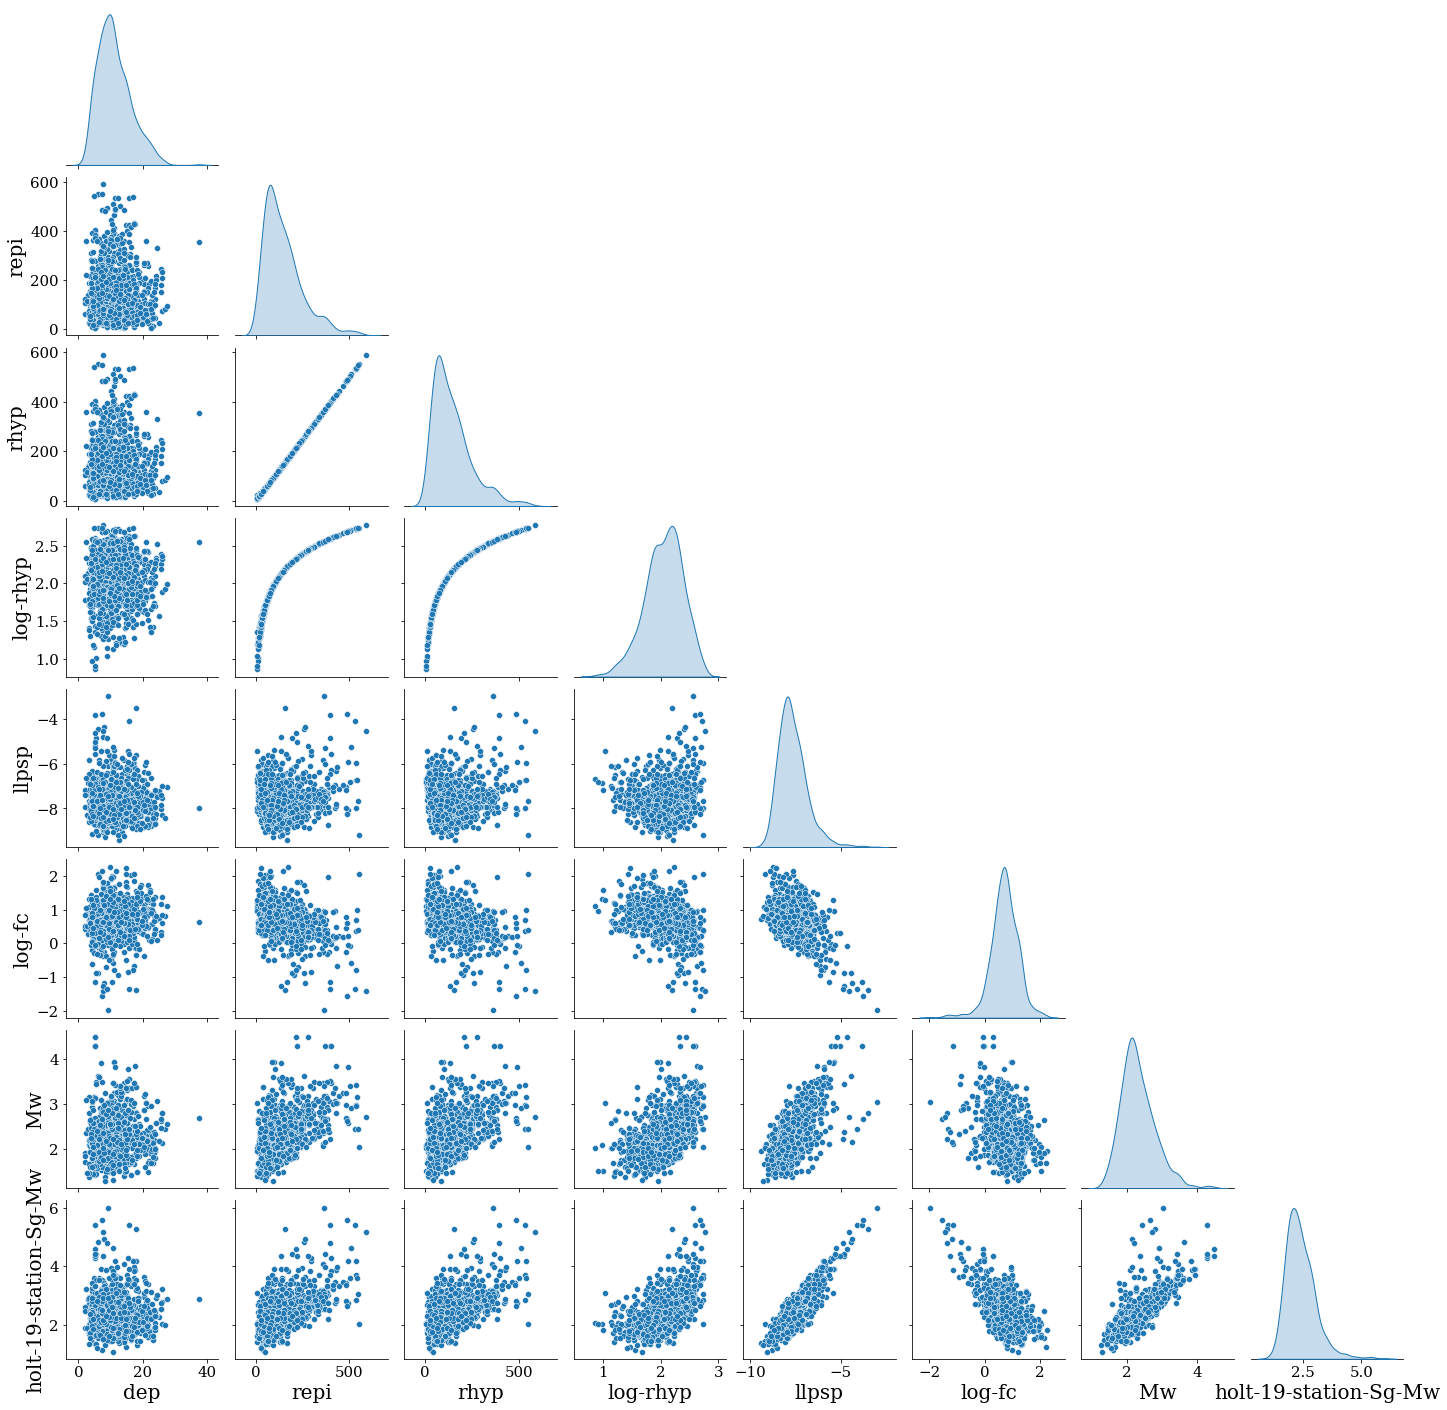

In [32]:
sns.pairplot(final_comb[['station', 'dep', 'repi', 'rhyp', 'log-rhyp', 'llpsp', 'log-fc', 'Mw', f"holt-19-station-{PHASE}g-Mw"]].sample(1000), diag_kind='kde', corner=True)

In [33]:
final_comb.corr()

dep      repi      rhyp     llpsp        fc  \
dep                    1.000000  0.003703  0.012716 -0.044208  0.039366   
repi                   0.003703  1.000000  0.999898  0.159581 -0.188387   
rhyp                   0.012716  0.999898  1.000000  0.160631 -0.187615   
llpsp                 -0.044208  0.159581  0.160631  1.000000 -0.160683   
fc                     0.039366 -0.188387 -0.187615 -0.160683  1.000000   
Mw                     0.068889  0.488830  0.488844  0.608768 -0.150901   
log-rhyp               0.018930  0.902210  0.899718  0.044940 -0.217897   
log-fc                 0.058826 -0.391945 -0.391453 -0.528640  0.640023   
holt-19-dist-corr      0.016183  0.891554  0.888883  0.041255 -0.207121   
holt-19-source-llpsp  -0.031258  0.543310  0.543016  0.891631 -0.234123   
source-vel-Sg          0.820777  0.011477  0.018211 -0.037883  0.027325   
source-density         0.893583  0.006686  0.014380 -0.042664  0.031256   
holt-19-station-Sg-M0  0.004942  0.015069  0.015119  0.127394 -0.006517   
holt-19-station-Sg-Mw  0.012063  0.543755  0.543816  0.889400 -0.232588   

                             Mw  log-rhyp    log-fc  holt-19-dist-corr  \
dep                    0.068889  0.018930  0.058826           0.016183   
repi                   0.488830  0.902210 -0.391945           0.891554   
rhyp                   0.488844  0.899718 -0.391453           0.888883   
llpsp                  0.608768  0.044940 -0.528640           0.041255   
fc                    -0.150901 -0.217897  0.640023          -0.207121   
Mw                     1.000000  0.463709 -0.275482           0.458838   
log-rhyp               0.463709  1.000000 -0.374512           0.987677   
log-fc                -0.275482 -0.374512  1.000000          -0.357775   
holt-19-dist-corr      0.458838  0.987677 -0.357775           1.000000   
holt-19-source-llpsp   0.739337  0.486794 -0.623594           0.489161   
source-vel-Sg          0.111172  0.030462  0.045456           0.027384   
source-density         0.097049  0.025821  0.050497           0.022764   
holt-19-station-Sg-M0  0.013317  0.012306 -0.091204           0.012271   
holt-19-station-Sg-Mw  0.744966  0.488238 -0.621009           0.490442   

                       holt-19-source-llpsp  source-vel-Sg  source-density  \
dep                               -0.031258       0.820777        0.893583   
repi                               0.543310       0.011477        0.006686   
rhyp                               0.543016       0.018211        0.014380   
llpsp                              0.891631      -0.037883       -0.042664   
fc                                -0.234123       0.027325        0.031256   
Mw                                 0.739337       0.111172        0.097049   
log-rhyp                           0.486794       0.030462        0.025821   
log-fc                            -0.623594       0.045456        0.050497   
holt-19-dist-corr                  0.489161       0.027384        0.022764   
holt-19-source-llpsp               1.000000      -0.020661       -0.026927   
source-vel-Sg                     -0.020661       1.000000        0.985421   
source-density                    -0.026927       0.985421        1.000000   
holt-19-station-Sg-M0              0.116768       0.001893        0.002867   
holt-19-station-Sg-Mw              0.998633       0.031611        0.024618   

                       holt-19-station-Sg-M0  holt-19-station-Sg-Mw  
dep                                 0.004942               0.012063  
repi                                0.015069               0.543755  
rhyp                                0.015119               0.543816  
llpsp                               0.127394               0.889400  
fc                                 -0.006517              -0.232588  
Mw                                  0.013317               0.744966  
log-rhyp                            0.012306               0.488238  
log-fc                             -0.091204              -0